# 1. Package importation

In [27]:
#  packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import string

# Data Augmentation
import random
import nltk
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')

# vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer

# classifiers
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

# pipeline
from sklearn.pipeline import Pipeline

# train and test split
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 2. Data Loading

In [29]:
# Chargement du fichier CSV depuis Google Drive
train_dataset = pd.read_csv("/kaggle/input/dataset-flowbert/training_data.csv")
test_dataset = pd.read_csv("/kaggle/input/dataset-flowbert/unlabelled_test_data.csv")


# View of the Data






In [30]:
train_dataset

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...,...
4795,4795,"C'est pourquoi, il décida de remplacer les hab...",B2
4796,4796,Il avait une de ces pâleurs splendides qui don...,C1
4797,4797,"Et le premier samedi de chaque mois, venez ren...",A2
4798,4798,Les coûts liés à la journalisation n'étant pas...,C2


# 3. Creation of new features

In [31]:
# Function to compute new features
def compute_features(dataframe):
    # Sentence lenght in words
    dataframe['word_count'] = dataframe['sentence'].apply(lambda x: len(x.split()))
    
    # Sentence lenght in characters
    dataframe['char_count'] = dataframe['sentence'].apply(lambda x: len(x))
    
    # Number of unique words
    dataframe['unique_word_count'] = dataframe['sentence'].apply(lambda x: len(set(x.split())))
    
    # Number of punctuation characters
    dataframe['punctuation_count'] = dataframe['sentence'].apply(lambda x: len([char for char in x if char in string.punctuation]))

    # Syntaxic complexity
    dataframe['average_word_length'] = dataframe['sentence'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)

    # Lexical diversity
    dataframe['lexical_diversity'] = dataframe['unique_word_count'] / dataframe['word_count']

    return dataframe

In [32]:
# Apply the function to create new features
train_dataset = compute_features(train_dataset)

# Display few rows
train_dataset.head()

,id,sentence,difficulty,word_count,char_count,unique_word_count,punctuation_count,average_word_length,lexical_diversity
0,0,Les coûts kilométriques réels peuvent diverger...,C1,38,255,29,8,5.736842,0.763158
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,12,62,12,4,4.250000,1.000000
2,2,Le test de niveau en français est sur le site ...,A1,13,66,12,2,4.153846,0.923077
3,3,Est-ce que ton mari est aussi de Boston?,A1,8,40,8,2,4.125000,1.000000
4,4,"Dans les écoles de commerce, dans les couloirs...",B1,34,209,28,9,5.176471,0.823529


# 4. Splitting the training data into a train and test set

In [33]:
# Préparer x avec les nouvelles fonctionnalités
# Assurez-vous d'exclure la colonne 'difficulty' ou toute autre colonne non caractéristique
x = train_dataset.drop(['difficulty'], axis=1)  # Exclure la colonne 'difficulty'
y = train_dataset['difficulty']  # y reste inchangé

# Séparation en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

# 5.  Approaches to create and evaluate models (without data cleaning)


In [34]:
# Identifier les caractéristiques textuelles et non textuelles dans x_train
text_features = 'sentence'  # Nom de la colonne de texte
numeric_features = x_train.drop(['sentence'], axis=1).columns.tolist()  # Liste des autres caractéristiques


In [35]:
# Préparer le ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(ngram_range=(1, 1)), text_features),
        ('num', 'passthrough', numeric_features)
    ])

In [37]:
# method to create a pipeline using Tfidf vectoriser and a classifier
def pipeline(classifier):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    return pipeline



In [39]:
# method to fit the models on the training set and make predictions
def fit_and_predict(pipeline):
  pipeline.fit(x_train, y_train)
  y_pred = pipeline.predict(x_test)
  return y_pred


In [41]:
def evaluation(y_test, y_pred):

    # compute and print the evaluation scores on the test set
    print('Accuracy = {:.4f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision = {:.4f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Recall = {:.4f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('F1-score = {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))

    # define the labels, plot and display the confusion matrix
    labels = list(unique_labels(y_test, y_pred))
    cfm = confusion_matrix(y_test, y_pred, labels = labels)
    fig, ax = plt.subplots(figsize=(6,6))
    plt.title('Confusion matrix of the model')
    sns.heatmap(cfm, annot=True, fmt='4g', cmap='PuRd', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()

In [46]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


# 6. Logistic Regression

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy = 0.4167
Precision = 0.4255
Recall = 0.4167
F1-score = 0.4108


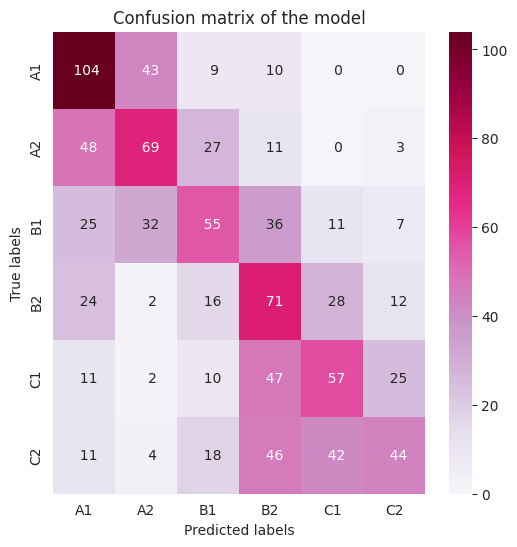

In [47]:
# define classifier
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=300)

# create pipeline
pipeline_lr = pipeline(lr)

# fit model on training set and make predictions
y_pred_lr = fit_and_predict(pipeline_lr)

# evaluate the model
lr_evaluation = evaluation(y_test, y_pred_lr)

# 7. k-Nearest Neighbors (kNN)

Accuracy = 0.3135
Precision = 0.3055
Recall = 0.3135
F1-score = 0.3020


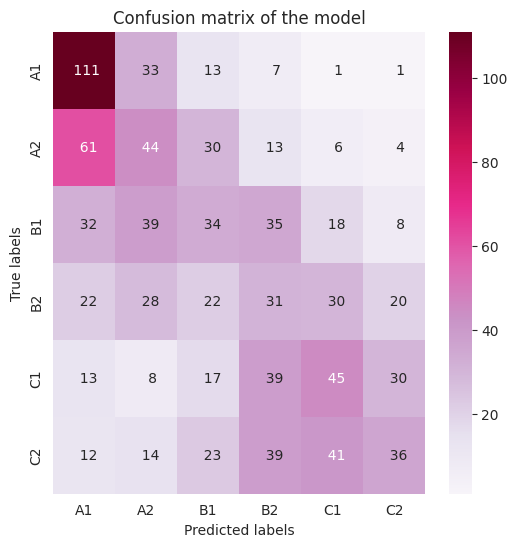

In [48]:
# define classifier
knn = KNeighborsClassifier()

# create pipeline
pipeline_knn = pipeline(knn)

# fit model on training set and make predictions
y_pred_knn = fit_and_predict(pipeline_knn)

# evaluate the model
knn_evaluation = evaluation(y_test, y_pred_knn)

# 8. Decision Tree

Accuracy = 0.3219
Precision = 0.3211
Recall = 0.3219
F1-score = 0.3212


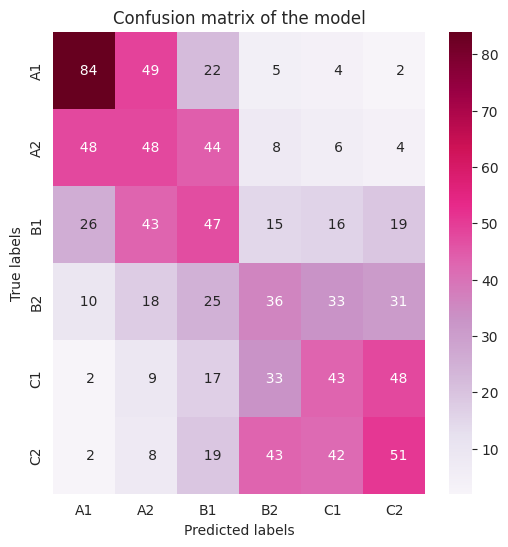

In [49]:
# define classifier
tree = DecisionTreeClassifier()

# create pipeline
pipeline_tree = pipeline(tree)

# fit model on training set and make predictions
y_pred_tree = fit_and_predict(pipeline_tree)

# evaluate the model
tree_evaluation = evaluation(y_test, y_pred_tree)

# 9. Random Forest



Accuracy = 0.4385
Precision = 0.4330
Recall = 0.4385
F1-score = 0.4306


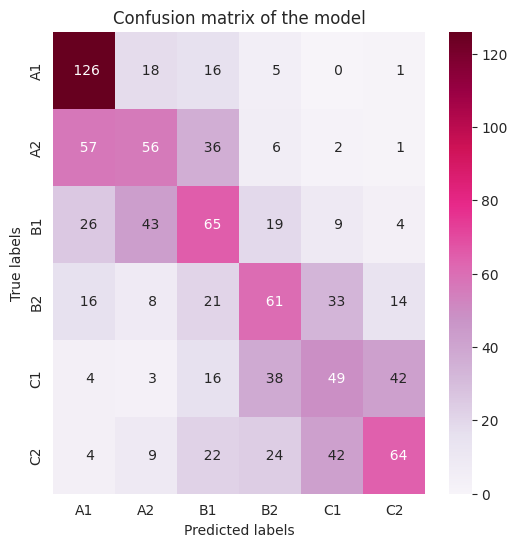

In [50]:
# define classifier
rf = RandomForestClassifier()

# create pipeline
pipeline_rf = pipeline(rf)

# fit model on training set and make predictions
y_pred_rf= fit_and_predict(pipeline_rf)

# evaluate the model
rf_evaluation = evaluation(y_test, y_pred_rf)